# Machine Learning's Capacity to Beat the Market -- Notebook
## Authors: Nathan Dejesus, Brandon Barker, Jack Lea, Mike Damiano, Ryan Schreck
---
The following notebook contains implemented machine learning algorithms to predict the [INSERT PREDICTION TARGET] for the [New York Stock Exchange dataset](https://www.kaggle.com/datasets/dgawlik/nyse/data?select=fundamentals.csv). The makeup consists of **Preprocessing**, **Implementations**, and **Analysis** concerning the data's features. 

In [2]:
######PREPROCESSING######
import pandas as pd

# Load the datasets
fundamentals = pd.read_csv('data/fundamentals.csv')
prices = pd.read_csv('data/prices.csv')
#prices_split_adjusted = pd.read_csv('data/prices-split-adjusted.csv')
#securities = pd.read_csv('data/securities.csv')

# Display a few rows of each dataset to check the data
fundamentals_preview = fundamentals.head()
prices_preview = prices.head()
#prices_split_adjusted_preview = prices_split_adjusted.head()
#securities_preview = securities.head()

#print(fundamentals_preview, prices_preview, prices_split_adjusted_preview, securities_preview)
print('fundamental shape: ', fundamentals.shape)
print('price shape: ', prices.shape)


# Convert date columns to datetime format for easier alignment and filtering
fundamentals['Period Ending'] = pd.to_datetime(fundamentals['Period Ending'], errors='coerce')
prices['date'] = pd.to_datetime(prices['date'], format='ISO8601', errors='raise')

print('fundamental shape: ', fundamentals.shape)
print('price shape: ', prices.shape)


fundamental shape:  (1781, 79)
price shape:  (851264, 7)
fundamental shape:  (1781, 79)
price shape:  (851264, 7)


In [3]:
# Ensure the company symbols match across datasets
common_symbols = set(fundamentals['Ticker Symbol']).intersection(set(prices['symbol']))

# Filter the datasets for common symbols only
fundamentals_filtered = fundamentals[fundamentals['Ticker Symbol'].isin(common_symbols)]
prices_filtered = prices[prices['symbol'].isin(common_symbols)]
#prices_split_adjusted_filtered = prices_split_adjusted[prices_split_adjusted['symbol'].isin(common_symbols)]

# Remove rows with NaT values in the date columns to avoid the 'NaTType' normalization error
fundamentals_filtered = fundamentals_filtered.dropna(subset=['Period Ending'])
prices_filtered = prices_filtered.dropna(subset=['date'])

# Preview the filtered datasets to confirm alignment based on common symbols
fundamentals_filtered_preview = fundamentals_filtered.head()
prices_filtered_preview = prices_filtered.head()
#prices_split_adjusted_filtered_preview = prices_split_adjusted_filtered.head()

#print(fundamentals_filtered_preview, prices_filtered_preview, prices_split_adjusted_filtered_preview)
print('shape: ', fundamentals_filtered.shape)
print('shape: ', prices_filtered.shape)

shape:  (1777, 79)
shape:  (760913, 7)


In [4]:
# Resample the prices data to a quarterly basis
prices_quarterly = prices_filtered.set_index('date').groupby('symbol').resample('QE').agg({
    'open': 'mean',
    'close': 'mean',
    'low': 'mean',
    'high': 'mean',
    'volume': 'sum'
}).reset_index()

# Display the resampled quarterly prices data
#print(prices_quarterly)
print(fundamentals_filtered.head())
print('shape: ', prices_quarterly.shape)

   Unnamed: 0 Ticker Symbol Period Ending  Accounts Payable  \
0           0           AAL    2012-12-31      3.068000e+09   
1           1           AAL    2013-12-31      4.975000e+09   
2           2           AAL    2014-12-31      4.668000e+09   
3           3           AAL    2015-12-31      5.102000e+09   
4           4           AAP    2012-12-29      2.409453e+09   

   Accounts Receivable  Add'l income/expense items  After Tax ROE  \
0         -222000000.0               -1.961000e+09           23.0   
1          -93000000.0               -2.723000e+09           67.0   
2         -160000000.0               -1.500000e+08          143.0   
3          352000000.0               -7.080000e+08          135.0   
4          -89482000.0                6.000000e+05           32.0   

   Capital Expenditures  Capital Surplus  Cash Ratio  ...  \
0         -1.888000e+09     4.695000e+09        53.0  ...   
1         -3.114000e+09     1.059200e+10        75.0  ...   
2         -5.311000e+09

In [5]:
# Align fundamentals with prices data based on company symbols and nearest corresponding quarters
# Merge fundamentals and quarterly prices data on 'Ticker Symbol' and 'symbol' (company symbols) and the nearest quarter end dates

# Renaming 'Ticker Symbol' in fundamentals to match 'symbol' for merging
fundamentals_filtered = fundamentals_filtered.rename(columns={'Ticker Symbol': 'symbol'})

# Merging with nearest join on date within the same quarter period
aligned_data = pd.merge_asof(prices_quarterly.sort_values('date'), 
                             fundamentals_filtered.sort_values('Period Ending'), 
                             by='symbol', 
                             left_on='date', 
                             right_on='Period Ending', 
                             direction='backward')

# Display a preview of the aligned dataset
#print(aligned_data.head())
print('shape: ', aligned_data.shape)
#print(aligned_data)


shape:  (12097, 85)


In [6]:
aligned_data_cleaned = aligned_data.dropna()
print('shape: ', aligned_data_cleaned.shape)
print(aligned_data_cleaned.head())

shape:  (5243, 85)
     symbol       date       open      close        low       high  \
3769    BBY 2012-03-31  25.046290  25.079355  24.710968  25.405806   
3993    BBY 2012-06-30  20.450794  20.450476  20.103492  20.842857   
4473    BBY 2012-09-30  18.744921  18.659206  18.329206  19.058254   
4624    CXO 2012-12-31  85.449033  85.178387  84.151451  86.481613   
4628    GPC 2012-12-31  62.536774  62.532419  62.011129  63.064678   

           volume  Unnamed: 0 Period Ending  Accounts Payable  ...  \
3769  384639000.0       206.0    2012-03-03      7.876000e+09  ...   
3993  568475600.0       206.0    2012-03-03      7.876000e+09  ...   
4473  602073500.0       206.0    2012-03-03      7.876000e+09  ...   
4624   61617200.0       424.0    2012-12-31      3.918140e+08  ...   
4628   47447900.0       704.0    2012-12-31      2.237638e+09  ...   

      Total Current Assets  Total Current Liabilities  Total Equity  \
3769          1.029700e+10               8.855000e+09  3.745000e+09 

In [7]:
##Visualization##
import matplotlib.pyplot as plt
import seaborn as sns

# Display descriptive statistics for the cleaned dataset
desc_stats = aligned_data_cleaned.describe()
print(desc_stats)

# Calculate correlations for key financial metrics and stock prices
print_corr = aligned_data_cleaned.drop(columns=['symbol']).corr().unstack().sort_values(ascending=False)
print(print_corr['open'])

                                date         open        close          low  \
count                           5243  5243.000000  5243.000000  5243.000000   
mean   2015-02-21 00:06:19.019645184    81.463859    81.485063    80.667313   
min              2012-03-31 00:00:00     3.558033     3.539016     3.328852   
25%              2014-03-31 00:00:00    41.380078    41.384880    40.923625   
50%              2015-03-31 00:00:00    62.286250    62.274098    61.771250   
75%              2015-12-31 00:00:00    90.117500    90.147109    89.195156   
max              2016-12-31 00:00:00  1495.351584  1493.179364  1482.457932   
std                              NaN    94.263709    94.267413    93.312302   

              high        volume   Unnamed: 0                  Period Ending  \
count  5243.000000  5.243000e+03  5243.000000                           5243   
mean     82.251132  2.731530e+08   901.313370  2014-09-20 13:40:56.074766592   
min       3.731587  7.792800e+06     0.000000   

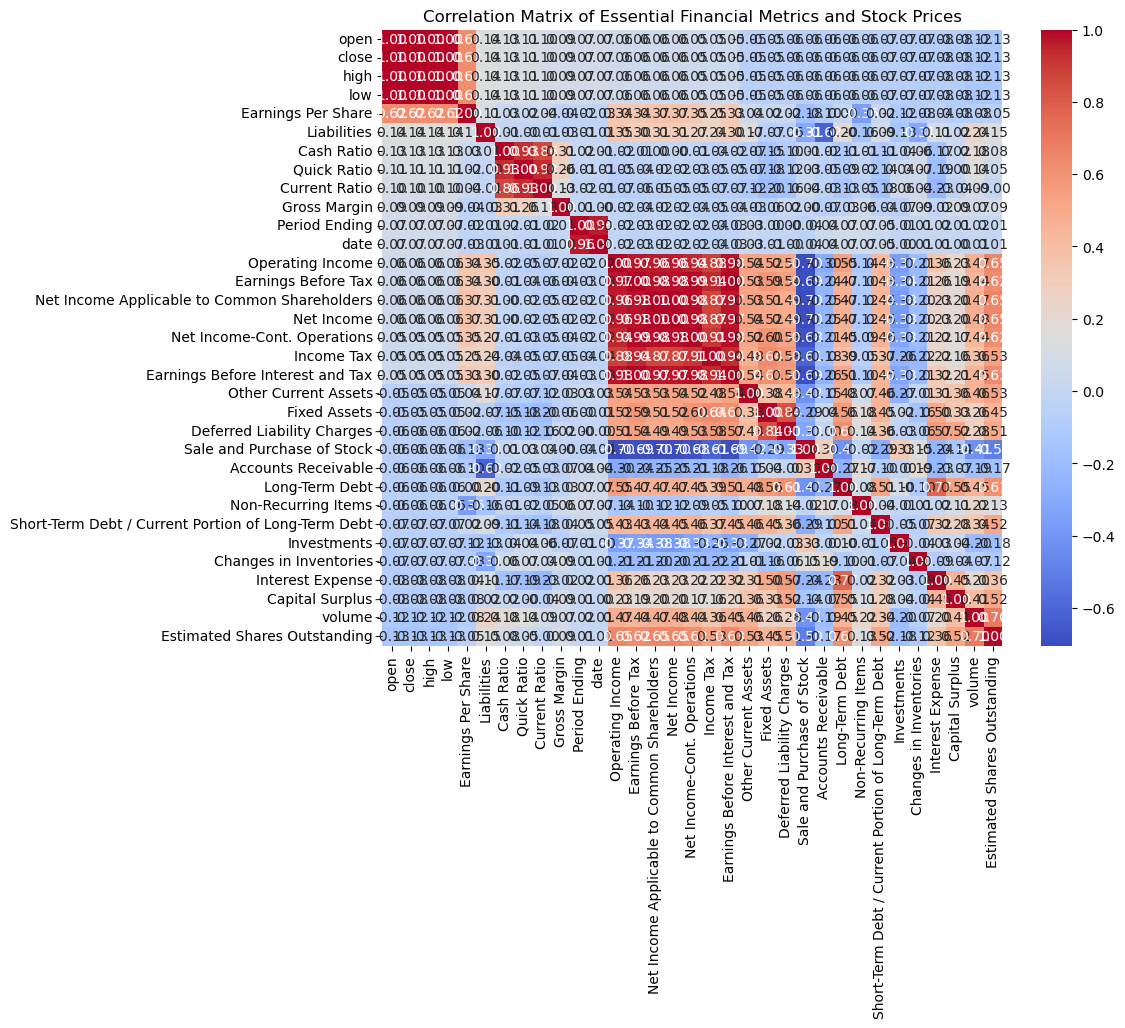

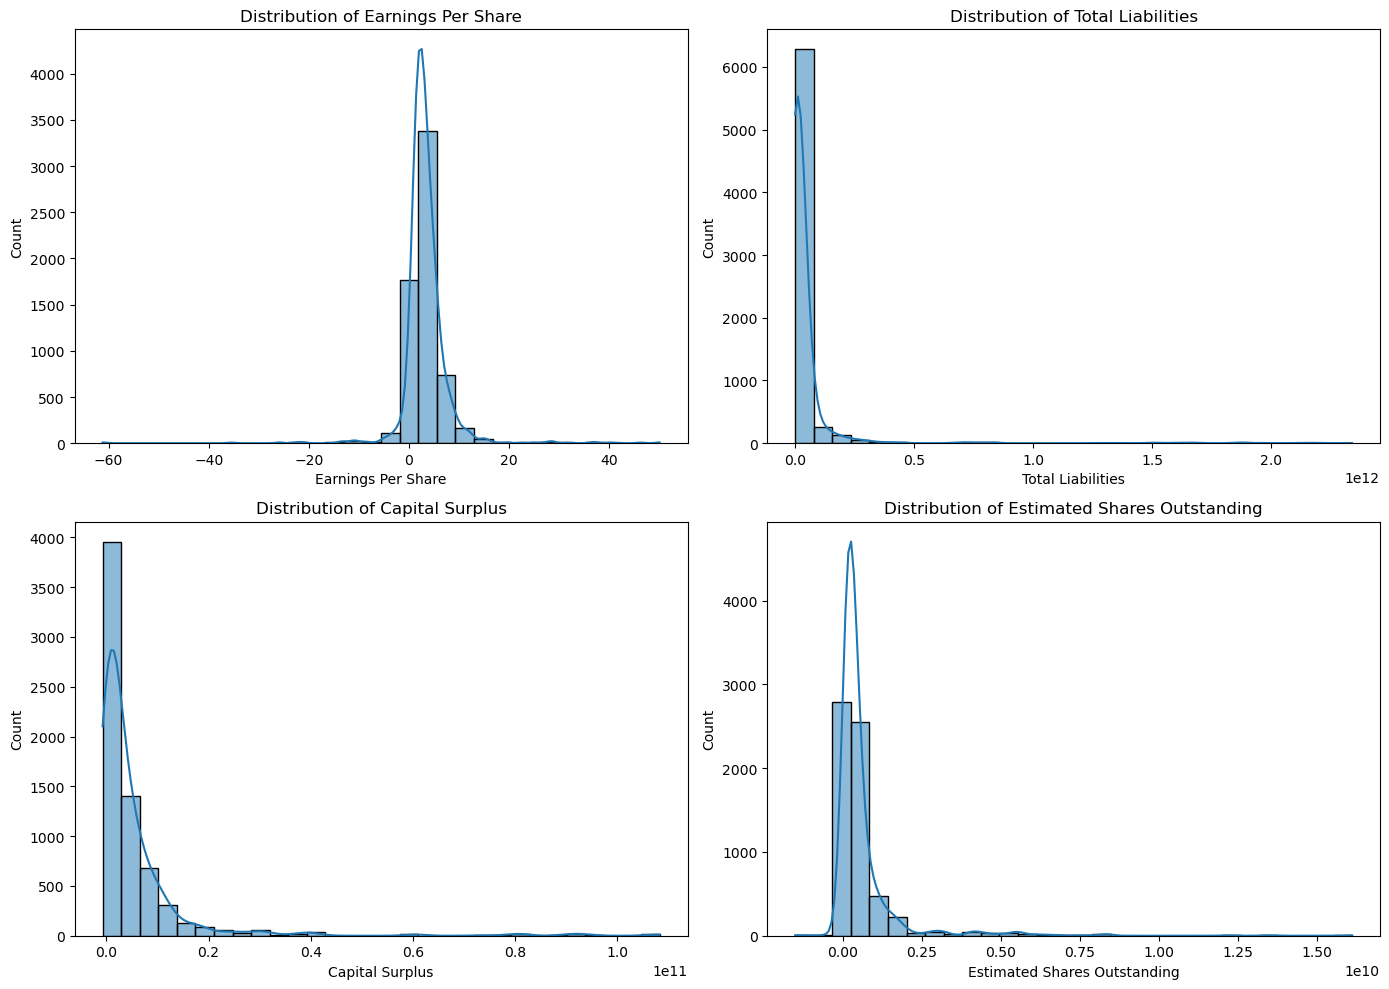

     symbol       open      close       high        low  Earnings Per Share  \
3769    BBY  25.046290  25.079355  25.405806  24.710968               -3.36   
3993    BBY  20.450794  20.450476  20.842857  20.103492               -3.36   
4473    BBY  18.744921  18.659206  19.058254  18.329206               -3.36   
4624    CXO  85.449033  85.178387  86.481613  84.151451                4.18   
4628    GPC  62.536774  62.532419  63.064678  62.011129                4.17   

      Liabilities  Cash Ratio  Quick Ratio  Current Ratio  ...  \
3769  576000000.0        14.0         52.0          116.0  ...   
3993  576000000.0        14.0         52.0          116.0  ...   
4473  576000000.0        14.0         52.0          116.0  ...   
4624   33388000.0         0.0         62.0           62.0  ...   
4628  220694000.0        16.0         89.0          194.0  ...   

      Accounts Receivable Long-Term Debt Non-Recurring Items  \
3769           41000000.0   1.685000e+09          29000000.0   


In [8]:
#I'm marking all features with above +- 0.05 correlation with 'open' as "essential columns"
essential_columns = [
    'open', 'close', 'high', 'low', 'Earnings Per Share', 'Liabilities', 'Cash Ratio', 'Quick Ratio', 
    'Current Ratio', 'Gross Margin', 'Period Ending', 'date', 'Operating Income', 'Earnings Before Tax',
    'Net Income Applicable to Common Shareholders', 'Net Income', 'Net Income-Cont. Operations', 'Income Tax', 
    'Earnings Before Interest and Tax', 'Other Current Assets', 'Fixed Assets', 'Deferred Liability Charges',
    'Sale and Purchase of Stock', 'Accounts Receivable', 'Long-Term Debt', 'Non-Recurring Items',
    'Short-Term Debt / Current Portion of Long-Term Debt', 'Investments', 'Changes in Inventories',
    'Interest Expense', 'Capital Surplus', 'volume', 'Estimated Shares Outstanding'
]
# Filter the dataset to include only the selected features along with the target variable 'close'
selected_data = aligned_data_cleaned[essential_columns]

correlation_matrix = selected_data.corr()
#print(correlation_matrix['open'])

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Essential Financial Metrics and Stock Prices")
plt.show()

# Plot distribution of a few key financial metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
sns.histplot(aligned_data['Earnings Per Share'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Distribution of Earnings Per Share")

sns.histplot(aligned_data['Total Liabilities'], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Distribution of Total Liabilities")

sns.histplot(aligned_data['Capital Surplus'], bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Distribution of Capital Surplus")

sns.histplot(aligned_data['Estimated Shares Outstanding'], bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Distribution of Estimated Shares Outstanding")

plt.tight_layout()
plt.show()

selected_data = aligned_data_cleaned[['symbol'] + essential_columns]
print(selected_data.head())
print('shape:', selected_data.shape)

In [9]:
securities_df = pd.read_csv('data/securities.csv')
securities_selected = securities_df[['Ticker symbol', 'GICS Sector', 'GICS Sub Industry']]

final_df = selected_data.merge(securities_selected, left_on='symbol', right_on='Ticker symbol', how='left')

final_df.drop(columns=['Ticker symbol'], inplace=True)
print(final_df.head())
final_df.shape

  symbol       open      close       high        low  Earnings Per Share  \
0    BBY  25.046290  25.079355  25.405806  24.710968               -3.36   
1    BBY  20.450794  20.450476  20.842857  20.103492               -3.36   
2    BBY  18.744921  18.659206  19.058254  18.329206               -3.36   
3    CXO  85.449033  85.178387  86.481613  84.151451                4.18   
4    GPC  62.536774  62.532419  63.064678  62.011129                4.17   

   Liabilities  Cash Ratio  Quick Ratio  Current Ratio  ...  \
0  576000000.0        14.0         52.0          116.0  ...   
1  576000000.0        14.0         52.0          116.0  ...   
2  576000000.0        14.0         52.0          116.0  ...   
3   33388000.0         0.0         62.0           62.0  ...   
4  220694000.0        16.0         89.0          194.0  ...   

   Non-Recurring Items Short-Term Debt / Current Portion of Long-Term Debt  \
0           29000000.0                                        523000000.0    
1       

(5243, 36)

In [11]:
######IMPLEMENTATION######
# Define target variable y
y = final_df['close']  # Percentage change in price for the next quarter

# Define features X (removed non-numerical 'Period Ending', 'date',) 
X = final_df[[ 
    'open', 'high', 'low', 'Earnings Per Share', 'Liabilities', 'Cash Ratio', 'Quick Ratio', 
    'Current Ratio', 'Gross Margin', 'Operating Income', 'Earnings Before Tax',
    'Net Income Applicable to Common Shareholders', 'Net Income', 'Net Income-Cont. Operations', 'Income Tax', 
    'Earnings Before Interest and Tax', 'Other Current Assets', 'Fixed Assets', 'Deferred Liability Charges',
    'Sale and Purchase of Stock', 'Accounts Receivable', 'Long-Term Debt', 'Non-Recurring Items',
    'Short-Term Debt / Current Portion of Long-Term Debt', 'Investments', 'Changes in Inventories',
    'Interest Expense', 'Capital Surplus', 'volume', 'Estimated Shares Outstanding'
]]

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply StandardScaler to X
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
## SKLEARN LINEAR REGRESSION
## 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Linear Regression
model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Degree: 1 (Linear Regression)")
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

Degree: 1 (Linear Regression)
Mean Squared Error: 0.0075580391807267035
R-squared Score: 0.9999989836373026


In [14]:
## SKLEARN POLYNOMIAL REGRESSION
##
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Degree 1 Polynomial Features (Linear Regression)
poly1 = PolynomialFeatures(degree=1)
X_train_poly1= poly1.fit_transform(X_train_scaled)
X_test_poly1 = poly1.transform(X_test_scaled)

model = LinearRegression()
model.fit(X_train_poly1, y_train)
y_pred = model.predict(X_test_poly1)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Degree: 1")
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

# Degree 2 Polynomial Features
poly2 = PolynomialFeatures(degree=2)
X_train_poly2= poly2.fit_transform(X_train_scaled)
X_test_poly2 = poly2.transform(X_test_scaled)

model = LinearRegression()
model.fit(X_train_poly2, y_train)
y_pred = model.predict(X_test_poly2)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Degree: 2")
print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

Degree: 1
Mean Squared Error: 0.007558039180726739
R-squared Score: 0.9999989836373026
Degree: 2
Mean Squared Error: 0.008646995460152584
R-squared Score: 0.9999988372005727


In [15]:
## CUSTOM POLYNOMIAL REGRESSION FUNCTION
import numpy as np

def predict(X, theta, degree):
    X_poly = add_polynomial_features(X, degree)
    return X_poly.dot(theta)

def add_polynomial_features(X, degree):
        X_poly = np.ones((X.shape[0], 1))  # Start with a column of ones (for the intercept)
        for d in range(1, degree + 1):
            X_poly = np.hstack((X_poly, X ** d))  # Add each polynomial degree column
        return X_poly
    
def polynomial_regression(X, y, degree, learning_rate, n_iterations, alpha, max_gradient=1e4):
    X_poly = add_polynomial_features(X, degree)
    y = y.reshape(-1, 1)
    m, n = X_poly.shape

    # Initialize theta (parameter vector) with zeros
    theta = np.zeros((n, 1))

    # Gradient descent
    for i in range(n_iterations):
        predictions = X_poly.dot(theta)
        errors = predictions - y
        gradients = (2 / m) * X_poly.T.dot(errors) + (2 * alpha * theta)

        # Clip gradients to prevent excessively large updates
        gradients = np.clip(gradients, -max_gradient, max_gradient)

        # Update theta
        theta -= learning_rate * gradients

    return theta

In [16]:
results = []
for degree in range(1, 4):  # Testing polynomial degrees 1-3
    theta = polynomial_regression(X_train_scaled, y_train.values, degree=degree, learning_rate=0.001, n_iterations=10000, alpha=0.01)

    # Ensure theta is valid before predicting
    if not np.isnan(theta).any():
        # Predict on the test set
        y_pred = predict(X_test_scaled, theta, degree)
        
        # Calculate evaluation metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results.append((degree, mse, r2))

# Convert results to a DataFrame for easier analysis
results_df = pd.DataFrame(results, columns=['Degree', 'Mean Squared Error', 'R-squared Score'])

# Display results
print(results_df.to_string(index=False))

 Degree  Mean Squared Error  R-squared Score
      1        1.200462e+00         0.999839
      2        3.836424e+00         0.999484
      3        3.140829e+07     -4222.611157
